In [ ]:
from torchvision.datasets import FashionMNIST
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(
    root ='.',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
test_dataset = torchvision.datasets.FashionMNIST(
    root ='.',
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

In [ ]:
#number of classes
K = len(set(train_dataset.targets.numpy()))
print(f'The number of classes is: {K}')

The number of classes is: 10


In [ ]:
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.activation import Softmax
from torch.nn.modules import MaxPool2d

class CNN_Arch5(nn.Module):
    def __init__(self):
      super(CNN_Arch5, self).__init__()
      # First convolution
      self.cnn1 = nn.Conv2d(in_channels=1 , out_channels=32 , kernel_size=3 , stride=1 )
      self.af1 = nn.Softmax()
      self.cnn2 = nn.Conv2d(in_channels=32 , out_channels=32, kernel_size=3 , stride=1 )
      self.af2 = nn.Softmax()
      self.mp1 = nn.MaxPool2d(kernel_size=2)
      self.do1 = nn.Dropout(0.25)
      
      # Second convolution
      self.cnn3 = nn.Conv2d(in_channels=32 , out_channels=64 , kernel_size=3 , stride=1 )
      self.af3 = nn.Softmax()
      self.cnn4 = nn.Conv2d(in_channels=64 , out_channels=64 , kernel_size=3 , stride=1 )
      self.af4 = nn.Softmax()
      self.mp2 = nn.MaxPool2d(kernel_size=2)
      self.do2 = nn.Dropout(0.25)
      # Third convolution
      self.fc1 = nn.Linear(1024  , 512)
      self.af4 = nn.Softmax()
      self.do4 = nn.Dropout(0.25)
      self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
      output = self.cnn1(x)
      output = self.af1(output)
      output = self.cnn2(output)
      output = self.af2(output)

      output = self.mp1(output)
      output = self.do1(output)
      output = self.cnn3(output)
      output = self.af3(output)

      output = self.cnn4(output)
      output = self.af4(output)
      output = self.mp2(output)
      output = self.do2(output)
      
      output = torch.flatten(output, 1)
      output = self.fc1(output)
      output = self.af4(output)
      output = self.do4(output)
      output = self.fc2(output)
      return output


In [ ]:
model = CNN_Arch5()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


CNN_Arch5(
  (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (af1): Softmax(dim=None)
  (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (af2): Softmax(dim=None)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do1): Dropout(p=0.25, inplace=False)
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (af3): Softmax(dim=None)
  (cnn4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (af4): Softmax(dim=None)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (do4): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.002)
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.002)
optimizer_rmsprop = torch.optim.RMSprop(model.parameters(), lr=0.002)

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  for it in range(epochs):
      model.train()
      t0 = datetime.now()
      train_loss = []
      for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        #backward and optimize
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
      # Get train loss and test loss
      train_loss = np.mean(train_loss)
      model.eval()
      test_loss = []
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
      test_loss = np.mean(test_loss)

      #save_losses
      train_losses[it] = train_loss
      test_losses[it] = test_loss

      dt = datetime.now() - t0
      print(f'Epoch {it + 1} / {epochs}, Train Loss: {train_loss:.4f}, \ Test Loss: {test_loss:.4f}, Duration: {dt}')
  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer_rmsprop, train_loader, test_loader, 50)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 / 50, Train Loss: 2.3030, \ Test Loss: 2.3028, Duration: 0:00:14.452701
Epoch 2 / 50, Train Loss: 2.3029, \ Test Loss: 2.3026, Duration: 0:00:08.409915
Epoch 3 / 50, Train Loss: 2.3030, \ Test Loss: 2.3027, Duration: 0:00:08.511552
Epoch 4 / 50, Train Loss: 2.3028, \ Test Loss: 2.3029, Duration: 0:00:08.507169
Epoch 5 / 50, Train Loss: 2.3029, \ Test Loss: 2.3029, Duration: 0:00:08.578280
Epoch 6 / 50, Train Loss: 2.3029, \ Test Loss: 2.3029, Duration: 0:00:09.491902
Epoch 7 / 50, Train Loss: 2.3029, \ Test Loss: 2.3029, Duration: 0:00:08.418117
Epoch 8 / 50, Train Loss: 2.3024, \ Test Loss: 2.2407, Duration: 0:00:08.387019
Epoch 9 / 50, Train Loss: 1.6268, \ Test Loss: 1.2405, Duration: 0:00:08.407562
Epoch 10 / 50, Train Loss: 1.3054, \ Test Loss: 0.9982, Duration: 0:00:08.378057
Epoch 11 / 50, Train Loss: 1.2088, \ Test Loss: 0.9014, Duration: 0:00:08.558489
Epoch 12 / 50, Train Loss: 1.1199, \ Test Loss: 0.8203, Duration: 0:00:08.553359
Epoch 13 / 50, Train Loss: 1.0175, \ 

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer_adam, train_loader, test_loader, 50)

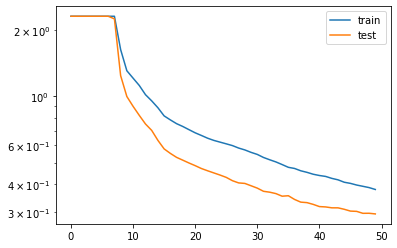

In [ ]:
plt.semilogy(train_losses, label='train')
plt.semilogy(test_losses, label='test')
plt.legend()
plt.show()

In [ ]:
# Accuracy, f1_score, precision
from sklearn.metrics import f1_score, precision_score
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
x_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
p_test = np.array([])
p_train = np.array([])
model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  p_train = np.concatenate((p_train, predictions.cpu().numpy()))
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
train_f1 = f1_score(y_train, p_train, average='micro')
train_precision = precision_score(y_train, p_train, average='micro')
train_acc = n_correct / n_total
n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
test_f1 = f1_score(y_test, p_test, average='micro')
test_precision = precision_score(y_test, p_test, average='micro')
test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')
print(f'Train f1_score: {train_f1:.4f}, Test f1_score: {test_f1:.4f}')
print(f'Train precision: {train_precision:.4f}, Test precision: {test_precision:.4f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserW

Train acc: 0.9074, Test acc: 0.8946
Train f1_score: 0.0992, Test f1_score: 0.0983
Train precision: 0.0992, Test precision: 0.0983
